# Воспроизводим Space Colonization Algorithm (Runions et al 2007) в его самом простом виде

In [3]:
%matplotlib inline

In [69]:
import numpy as np

from numpy import array, arange, zeros, ones, sin, cos, pi
from numpy import linalg

from importlib import reload
import sys

from pathlib import Path

import itertools as itt

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_12341/842006039.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


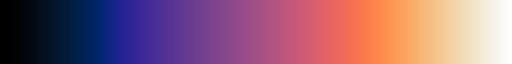

In [70]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.lines import Line2D
import cmasher as cmr

from matplotlib.pyplot import figure, gcf, gca, plot, close, xlim, ylim, xlabel, ylabel, title,\
                              subplots
from cycler import cycler
plt.style.use('seaborn-dark')

sequential_map = 'cmr.torch'
gradient_map = 'BuPu'
diverging_map = 'cmr.viola'
cyclic_map = 'twilight_shifted'

plt.rcParams['image.cmap'] = sequential_map
plt.get_cmap(sequential_map)

In [71]:
import scipy as sp
from scipy import ndimage as ndi
from scipy import stats


In [72]:
# import plotly.express as px

In [73]:
import networkx as nx 

In [74]:
from tqdm.auto import tqdm

## How to implement attraction points?
Easiest is to have them as an array or list. This list will be updated to remove points within killing distance or may be add more points at some stage

## How to implement the TreeNodes? Let's say we want to build data representation from scratch

This in some sense is a poor man's directed graph. NetworkX can turn out to be easier to work with in the end

For a node we should be able to:
 - [X] assign a parent (single) node. Can be empty (root)
 - [X] attach a new child node. A list of child nodes can be empty (tip). 
 - [ ] follow all upstream nodes recursively (or after conversion to NetworkX, iteratively
 - [ ] follow all downstream nodes recursively or iteratively
 - [X] update the set of attraction points for which this node is the nearest (and within distance of influence)
 - [X] Plot the given node as a point and edges to all child nodes as lines. May be tuned to plot smaller point if the node is a tip 

This implementation should be minimal enough to be re-written from scratch any time.

In [75]:
class PointCloud:
    def __init__(self, R=2, Npoints=1000, center = [0, 0, 0]):
        # self.cloud = set() if cloud is None else cloud
        self.cloud = None
        self.radius = R
        self.Npoints = Npoints
        self.center = center
    
    def Cube(self):
        if self.cloud is None:
            self.cloud = self.radius*(np.random.rand(self.Npoints,3) - 0.5)
            return self.cloud
    
    def Sphere(self, non_uniform = False, uni=2):

        def inner_points(R, center, uni=1):
            if uni == 1:

                while True:
                    x = np.random.random()*2 - 1
                    y = np.random.random()*2 - 1
                    z = np.random.random()*2 - 1
                    h, k, l = center
                    
                    if (x-h)**2 + (y-k)**2 + (z-l)**2 <= R**2:
                        return np.array([x, y, z])
            else:
                while True:
                    x = np.random.exponential()*uni - 1
                    y = np.random.exponential()*uni - 1
                    z = np.random.exponential()*uni - 1
                    h, k, l = center
                    
                    if (x-h)**2 + (y-k)**2 + (z-l)**2 <= R**2:
                        return np.array([x, y, z])

        if self.cloud is None and non_uniform==False:
            cloud = []
            for n in range(self.Npoints):
                cloud.append(inner_points(self.radius, self.center))
            self.cloud = np.array(cloud)
            return self.cloud 
           
        elif self.cloud is None and non_uniform==True:
            cloud = []
            for n in range(self.Npoints):
                cloud.append(inner_points(self.radius, self.center, uni=uni))
            self.cloud = np.array(cloud)
            return self.cloud
    
    def Sphere_surface(self):
        def sample_spherical(npoints, ndim=3):
            vec = np.random.randn(ndim, npoints)
            vec /= np.linalg.norm(vec, axis=0)
            return vec
        
        xi, yi, zi = sample_spherical(self.Npoints)
        r = self.radius
        self.cloud = np.array(list((zip(r*xi, r*yi, r*zi))))
        return self.cloud

    def CustomCloud(self, my_cloud):
        self.cloud = my_cloud
        return self.cloud
        
    # def Voronoi_cell():
    #     pass

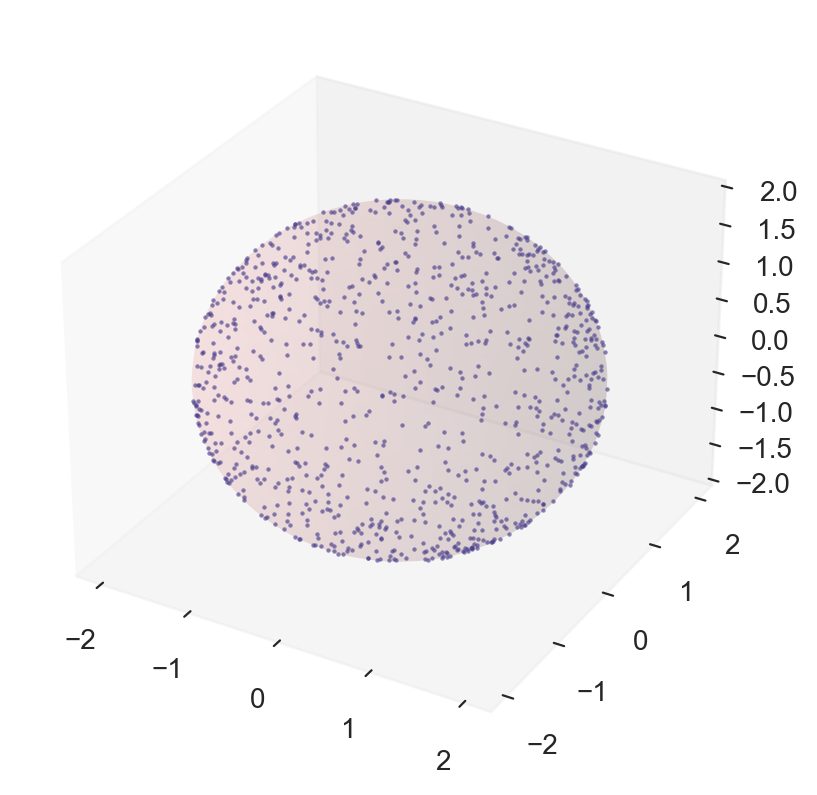

In [76]:
Cloud = PointCloud()
sources_1 = Cloud.Sphere(non_uniform=True)
sources_2 = Cloud.Cube()
sources_3 = Cloud.Sphere_surface()
sources = sources_3
R = Cloud.radius

fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
ax.plot(sources[:, 0], sources[:, 1], sources[:, 2], 'o', color='darkslateblue', alpha=0.6, ms=0.6)

u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = R*np.cos(u)*np.sin(v)
y = R*np.sin(u)*np.sin(v)
z = R*np.cos(v)

ax.plot_surface(x, y, z, color="lightcoral", alpha=0.1)
ax.set_facecolor('white')
fig.set_facecolor('white')
ax.grid(False)

In [77]:
Cloud.__dict__

{'cloud': array([[ 0.7058151 , -1.40680587, -1.23398634],
        [-1.87920583, -0.45979546,  0.50712287],
        [-1.32006835, -0.41354847,  1.44443664],
        ...,
        [-1.1701768 ,  0.86145464,  1.37425694],
        [-1.72478708,  0.72791621, -0.70373824],
        [ 1.73342749,  0.63614799,  0.76846918]]),
 'radius': 2,
 'Npoints': 1000,
 'center': [0, 0, 0]}

In [78]:
# this should be converted to networkX Digraph eventually
class TreeNode:
    max_branches=5 # safety switch to prevent infinite branching
    def __init__(self, v, rad=0.125, parent=None, tree=None):
        self.parent = parent
        self.radius = rad
        self.tree = set() if tree is None else tree
        self.tree.add(self)
        if parent is not None and not self in parent.children:
            parent.children.append(self)
            
        self.children = []
        self.v = np.array(v) # spatial coordinate of the node
    
    def spawn(self, 
              S : "attractor set", 
              Dg : "growth distance" = 0.025, 
              eps=0.00001,
              jitter=0.01,
              verbose=False):
        
        if not len(S):
            return
        S = np.array(S)
        d = (S - self.v)
        
        n = np.sum(d/(1e-6 + linalg.norm(d, axis=1)[:,np.newaxis]), axis=0)
                
        nnorm = np.linalg.norm(n)            
        
        n = n / (1e-6 + nnorm)
            
        vdash = self.v + Dg*n
                
        if len(self.children) < self.max_branches:
            tip = TreeNode(vdash, parent=self, tree=self.tree)

In [79]:
def space_colonization(tree, sources, iterations=20, Dg=0.025, Di=1, Dk=0.025, return_params=False):

    for j in tqdm(range(iterations)):
        
        tree_prev = [n for n in tree if len(n.children) <= n.max_branches]
        
        kdt = sp.spatial.KDTree([n.v for n in tree_prev])
        
        d,inds = kdt.query(sources, distance_upper_bound=Di)
            
        if len(d) and np.min(d) > Di:
            d,inds = kdt.query(sources, distance_upper_bound=np.min(d))
            
        for i, n in enumerate(tree_prev):
            S = sources[inds==i]
            n.spawn(S, Dg)
                    
        kdt2 = sp.spatial.KDTree([n.v for n in tree])
        too_close = kdt2.query_ball_point(sources, Dk, return_length=True)        
        sources = sources[too_close == 0] 
        
        if not len(sources):
            break
        
        # add small jitter to break up ties
        sources  = sources + np.random.randn(*sources.shape)*Dg*0.05
    
    if return_params == True:
        parameters = {'# iterations': iterations,
                'Growth Distance (Dg)': Dg,
                'Influence Distance (Di)': Di,
                'Kill Distance (Dk)': Dk,
                '# sources': len(sources),
                '# nodes': len(tree)
                    }
        return tree, sources, parameters 
    
    return tree, sources

def set_thickness(tree):
    pass
    # root = 
    # terminals = 

***Branch thickness***

*For terminals*:
$$ T_{t} = r_{extr} $$
*For other branches*:
$$ T_{b} = \sum_{n=1}^{N_{children}} {(Children[n]*size^{Dg})}^{1/Dg} $$


In [80]:
def plot_tree(tree, root=None, sources=None, ax=None, view_init=None,
               grid = True, show_sources =True, show_leaflets=True, params = None):
    
    if ax is None:
        fig = plt.figure(dpi=350)
        ax = fig.add_subplot(projection='3d')

    if root is not None:
        ax.plot(root.v[0], root.v[1], root.v[2], 'ro')
    for n in tree:
        v = n.v
        for ch in n.children:
            vx = np.vstack([v, ch.v])
            plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)
    if sources is not None and show_sources == True:
        ax.plot(sources[:,0], sources[:,1], sources[:, 2], '.', color='salmon', ms=0.5)
    ax.axis('equal')

    if view_init is not None:
        elev, azim = view_init
        ax.view_init(elev=elev, azim=azim)
    if grid == False:
        ax.grid(False)
        ax.axis('off')
    if show_leaflets == True:
        terminals = np.array([n.v for n in tree if len(n.children) == 0])
        ax.plot(terminals[:, 0], terminals[:, 1], terminals[:, 2], 'o', color = 'maroon', ms=1.5)
    if params is not None:
        ax.legend

def plot_skinned_tree(tree, root=None, sources=None, ax=None):
    from matplotlib.patches import Polygon
    
    pass


In [81]:
#plot_tree(tree, root)

In [82]:
#len(sources)

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_12341/4168554677.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


KeyboardInterrupt: 

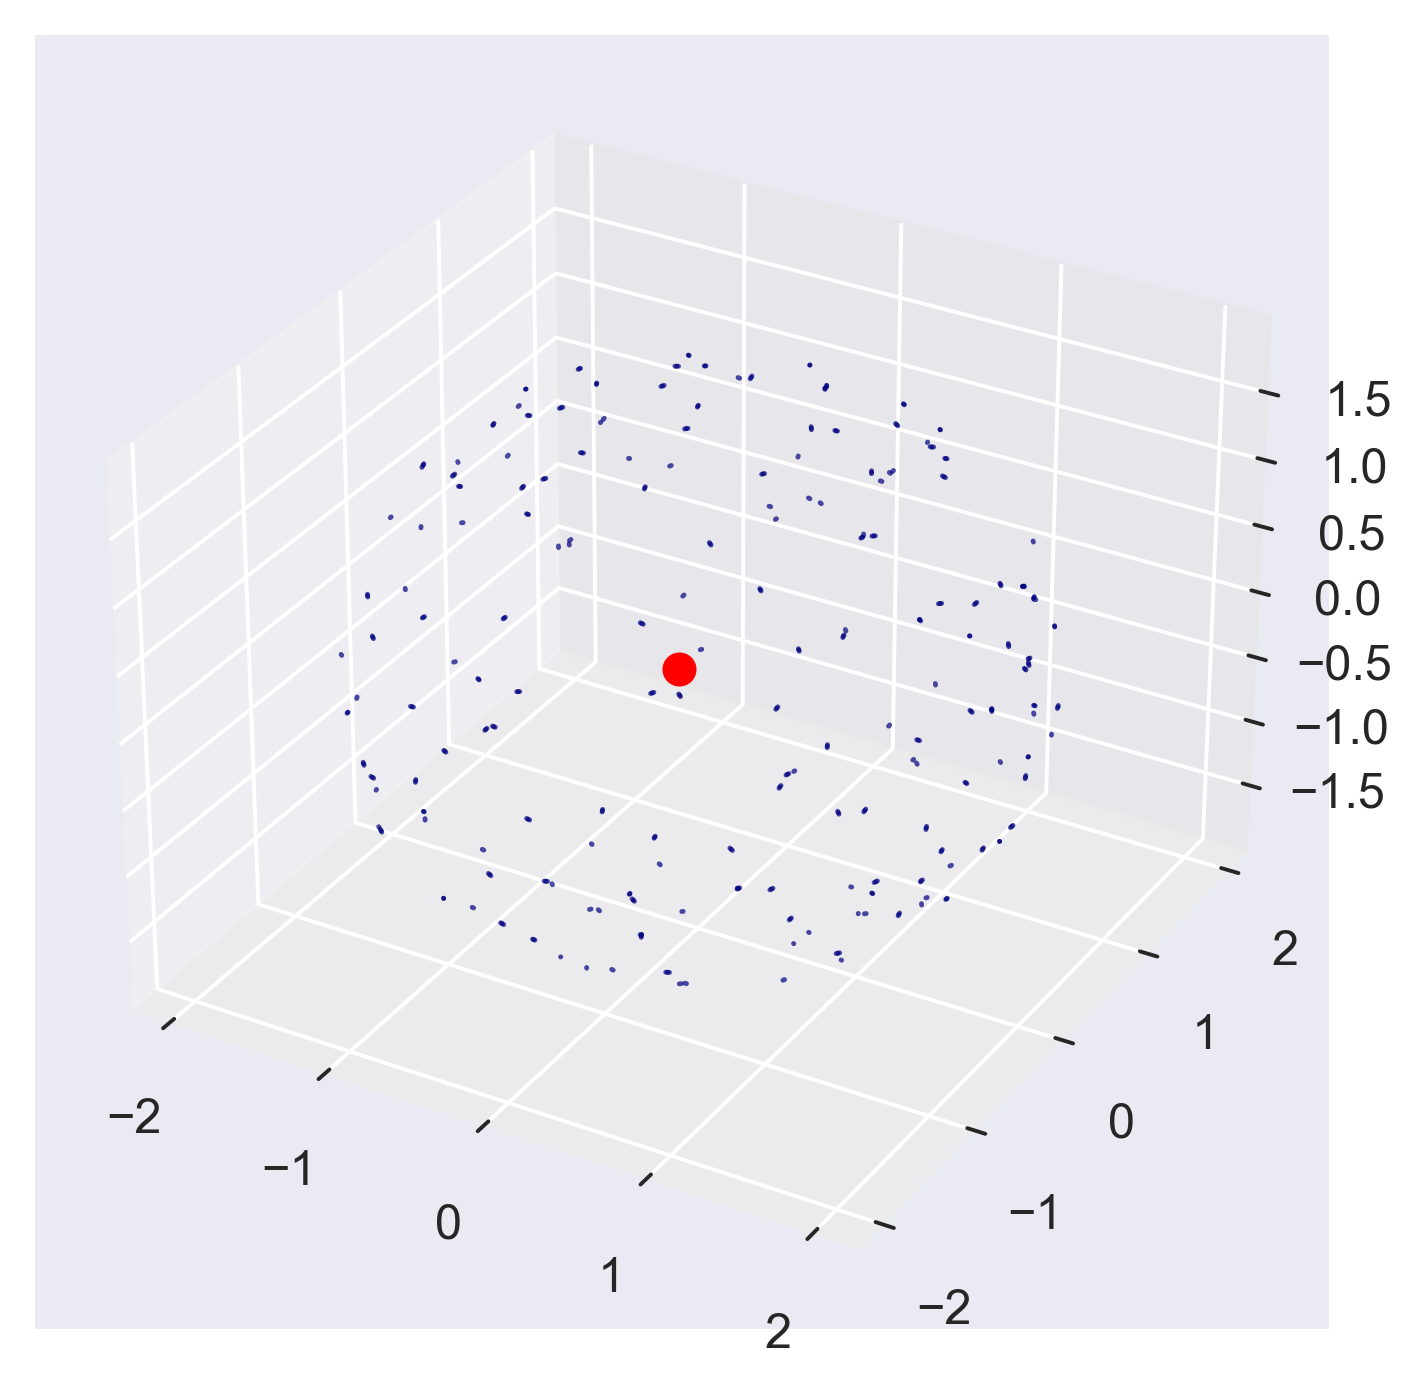

In [83]:
tree = set()
root = TreeNode([-0,-0.2, 0.1], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=10,
                                                 Dg=0.01,
                                                 Dk=0.1,
                                                )
plot_tree(new_tree, root, sources)
ax.set_facecolor('white')
fig.set_facecolor('white')
plt.grid('False')
plt.title('Dinfluence = 10')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_6543/1207814207.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 0.92, 'Dinfluence = 0.25')

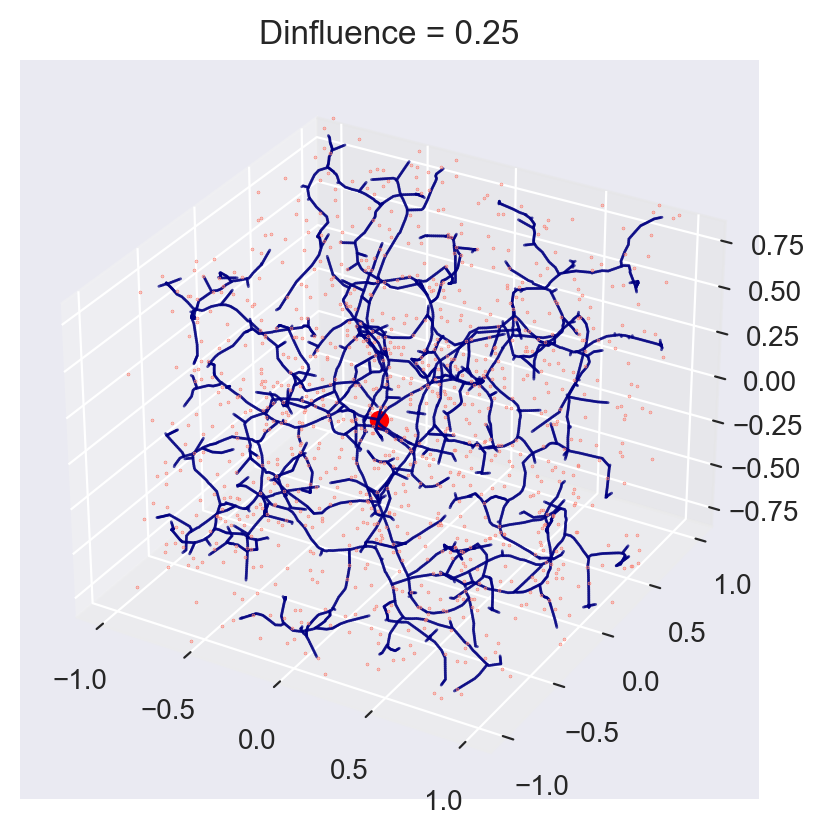

In [97]:
tree = set()
root = TreeNode([-0,-0.2, 0.1], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=0.25,
                                                 Dg=0.01,
                                                 Dk=0.1,
                                                )
plot_tree(new_tree, root, sources)
plt.title('Dinfluence = 0.25')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_73469/1207814207.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 0.92, 'Dinfluence = 0.25')

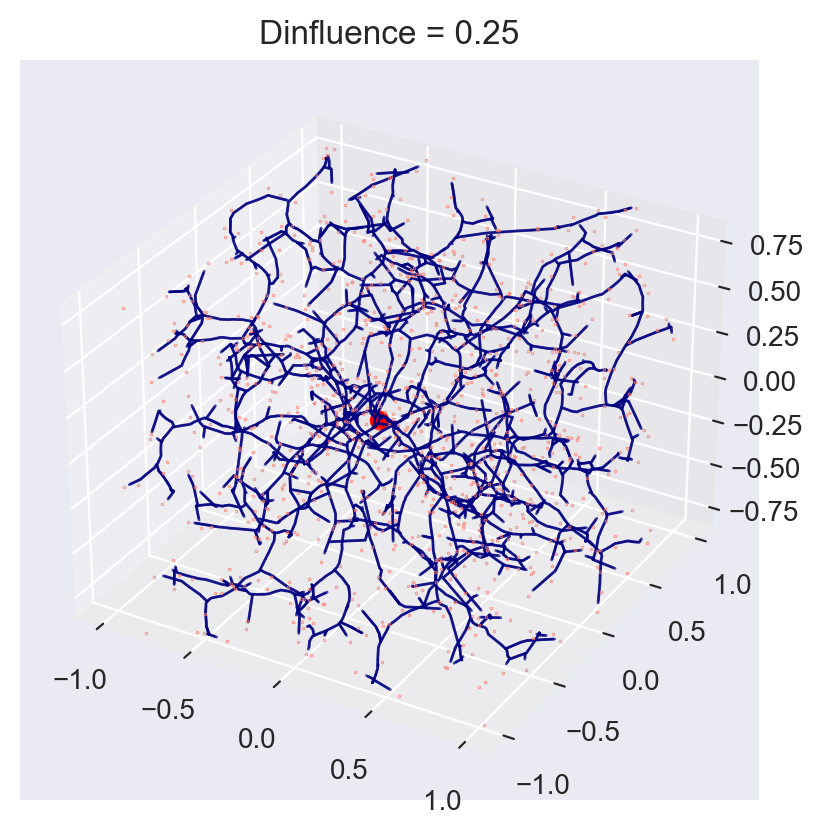

In [89]:
tree = set()
root = TreeNode([-0,-0.2, 0.1], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=0.25,
                                                 Dg=0.01,
                                                 Dk=0.05,
                                                )
plot_tree(new_tree, root, sources)
plt.title('Dinfluence = 0.25')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_73469/1207814207.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 0.92, 'Di = 0.01, Dk=0.01')

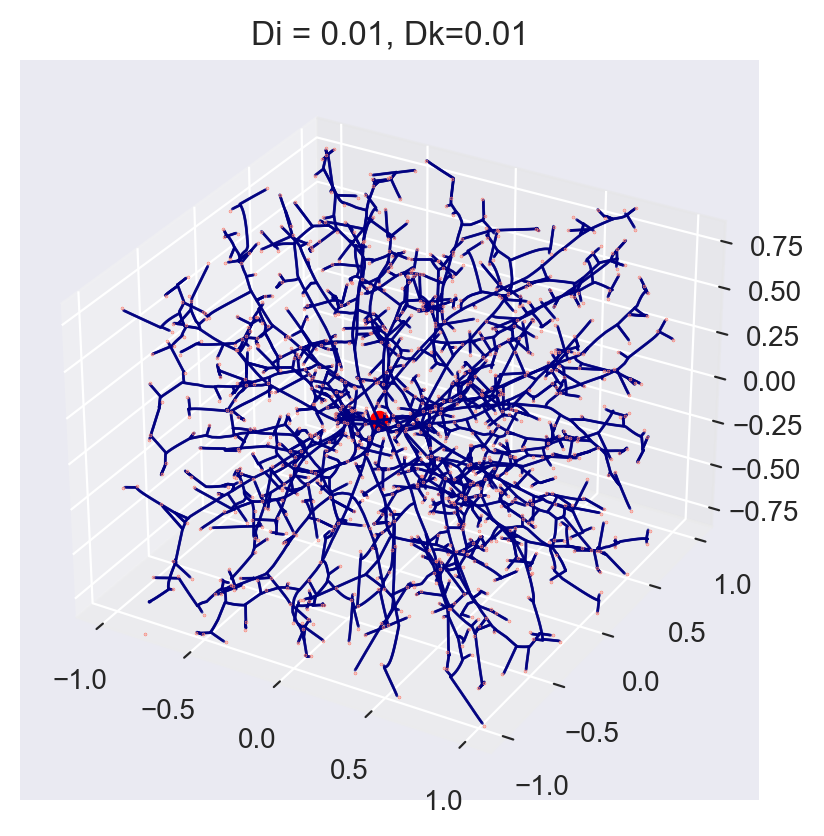

In [91]:
tree = set()
root = TreeNode([-0,-0.2, 0.1], tree=tree)
root.max_branches = 5

Di = 0.01
Dk = 0.01

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=Di,
                                                 Dg=0.005,
                                                 Dk=Dk,
                                                )
plot_tree(new_tree, root, sources)
plt.title(f'Di = {Di}, Dk={Dk}')

In [79]:
len(sources), len(remaining_sources)

(5000, 0)

In [103]:
# сделать смешной point cloud благодаря загрузке объекта через pymesh
import open3d as o3d

bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
pcd = mesh.sample_points_poisson_disk(5000)
center = pcd.get_center()

bunny_cloud = np.asarray(pcd.points)

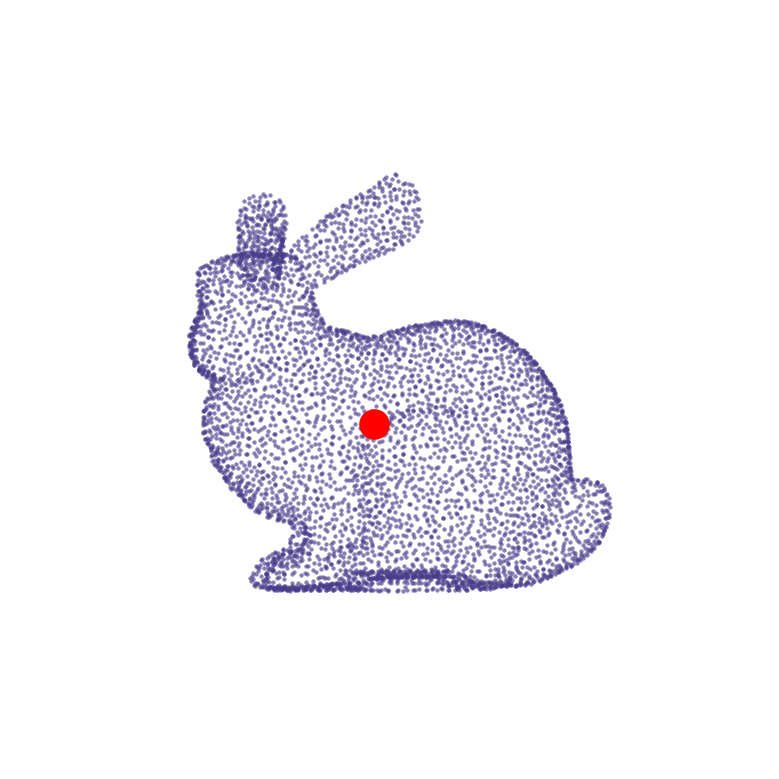

In [191]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
ax.plot(bunny_cloud[:, 0], bunny_cloud[:, 1], bunny_cloud[:, 2], 'o', color='darkslateblue', alpha=0.6, ms=0.6)

x, y, z = center
ax.plot(x, y, z, 'o',color="r", ms=10)
ax.set_facecolor('white')
fig.set_facecolor('white')
ax.grid(False)
ax.axis('off')
ax.view_init(elev=90, azim=265)

  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_32101/1468984353.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 0.92, 'Dinfluence = 10')

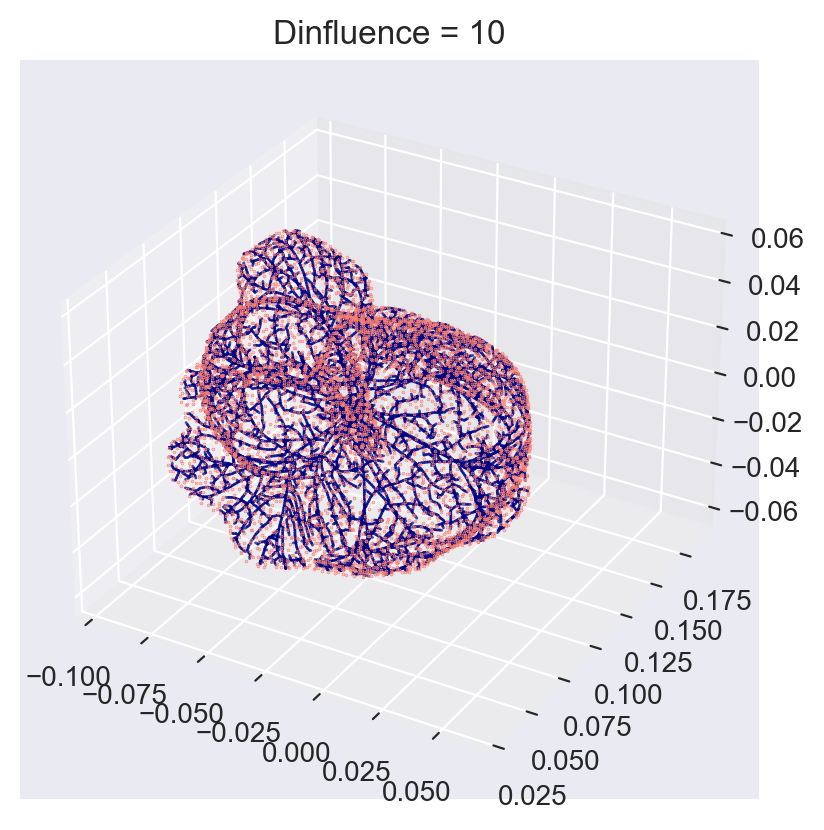

In [168]:
tree = set()
root = TreeNode(center, tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=5000,
                                                 Di=1,
                                                 Dg=0.001,
                                                 Dk=0.002,
                                                )


/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_32101/1973791078.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 0.92, 'Di=1, Dg=0.001, Dk=0.002')

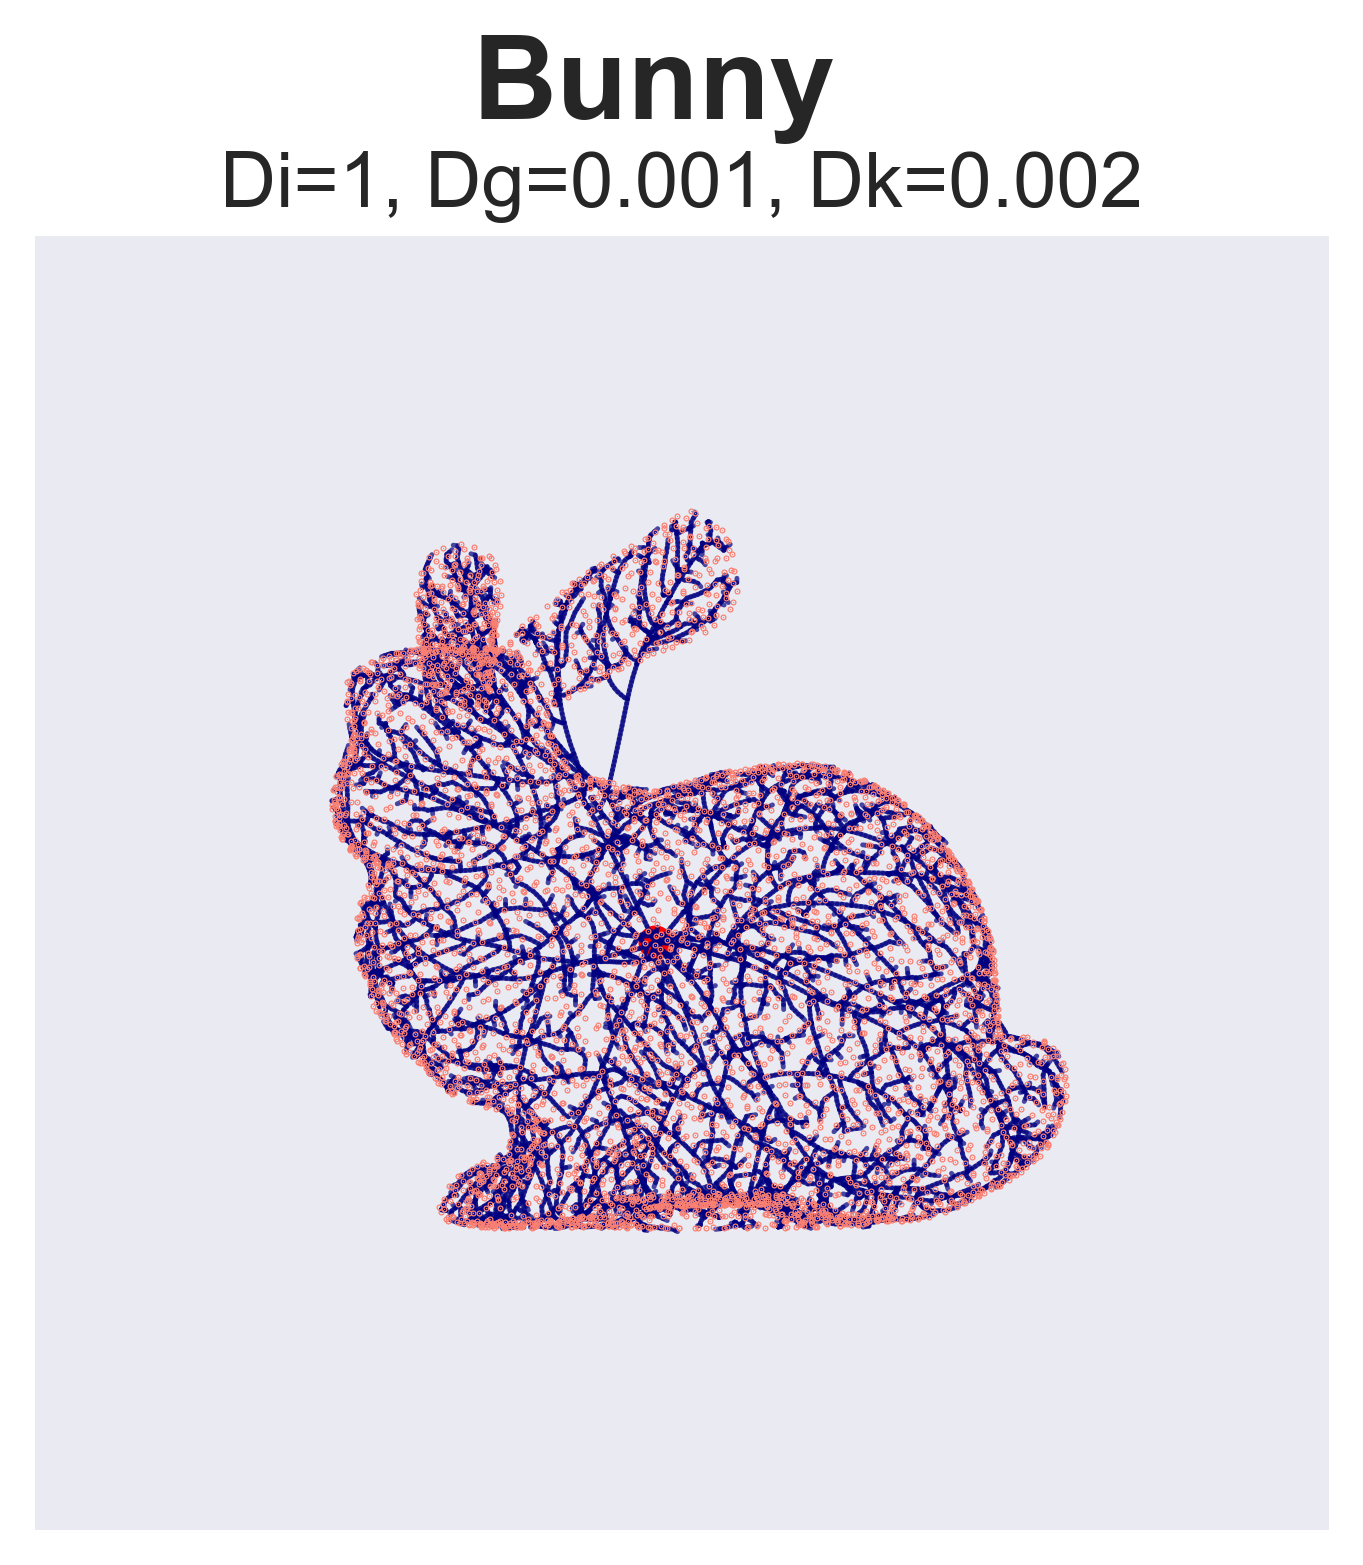

In [187]:
plot_tree(new_tree, root, sources, view_init=(90, 265), grid=False)
plt.suptitle('Bunny', weight='bold',fontsize=24, y=1)
plt.title('Di=1, Dg=0.001, Dk=0.002',fontsize=16)


## Let's try NetworkX next

array([ 0. , -0.2,  0.1])

In [120]:
def tree_to_graph(tree, optimize_graph=False):
    def get_node(node):
        '''
        represent node as tuple
        '''
        v = node.v
        return tuple(v)
    root = [i for i in tree if i.parent == None][0]
    graph = nx.DiGraph()
    segms = [(get_node(node.parent), get_node(node)) for node in tree if node != root]
    children = root.children
    root_connect = [(get_node(root), get_node(child)) for child in children]
    graph.add_node(get_node(root), root = get_node(root))
    graph.add_nodes_from([get_node(node) for node in tree if node != root], root = get_node(root))
    graph.add_edges_from(segms, root = get_node(root))
    graph.add_edges_from(root_connect, root = get_node(root))

    return graph
    

In [121]:
def get_tips(g):
    return {n for n in g.nodes if len(list(g.successors(n))) == 0}

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/anyak/Documents/Lab/AstroSpace/AstroSpace-main/AstroSpace/SCA.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


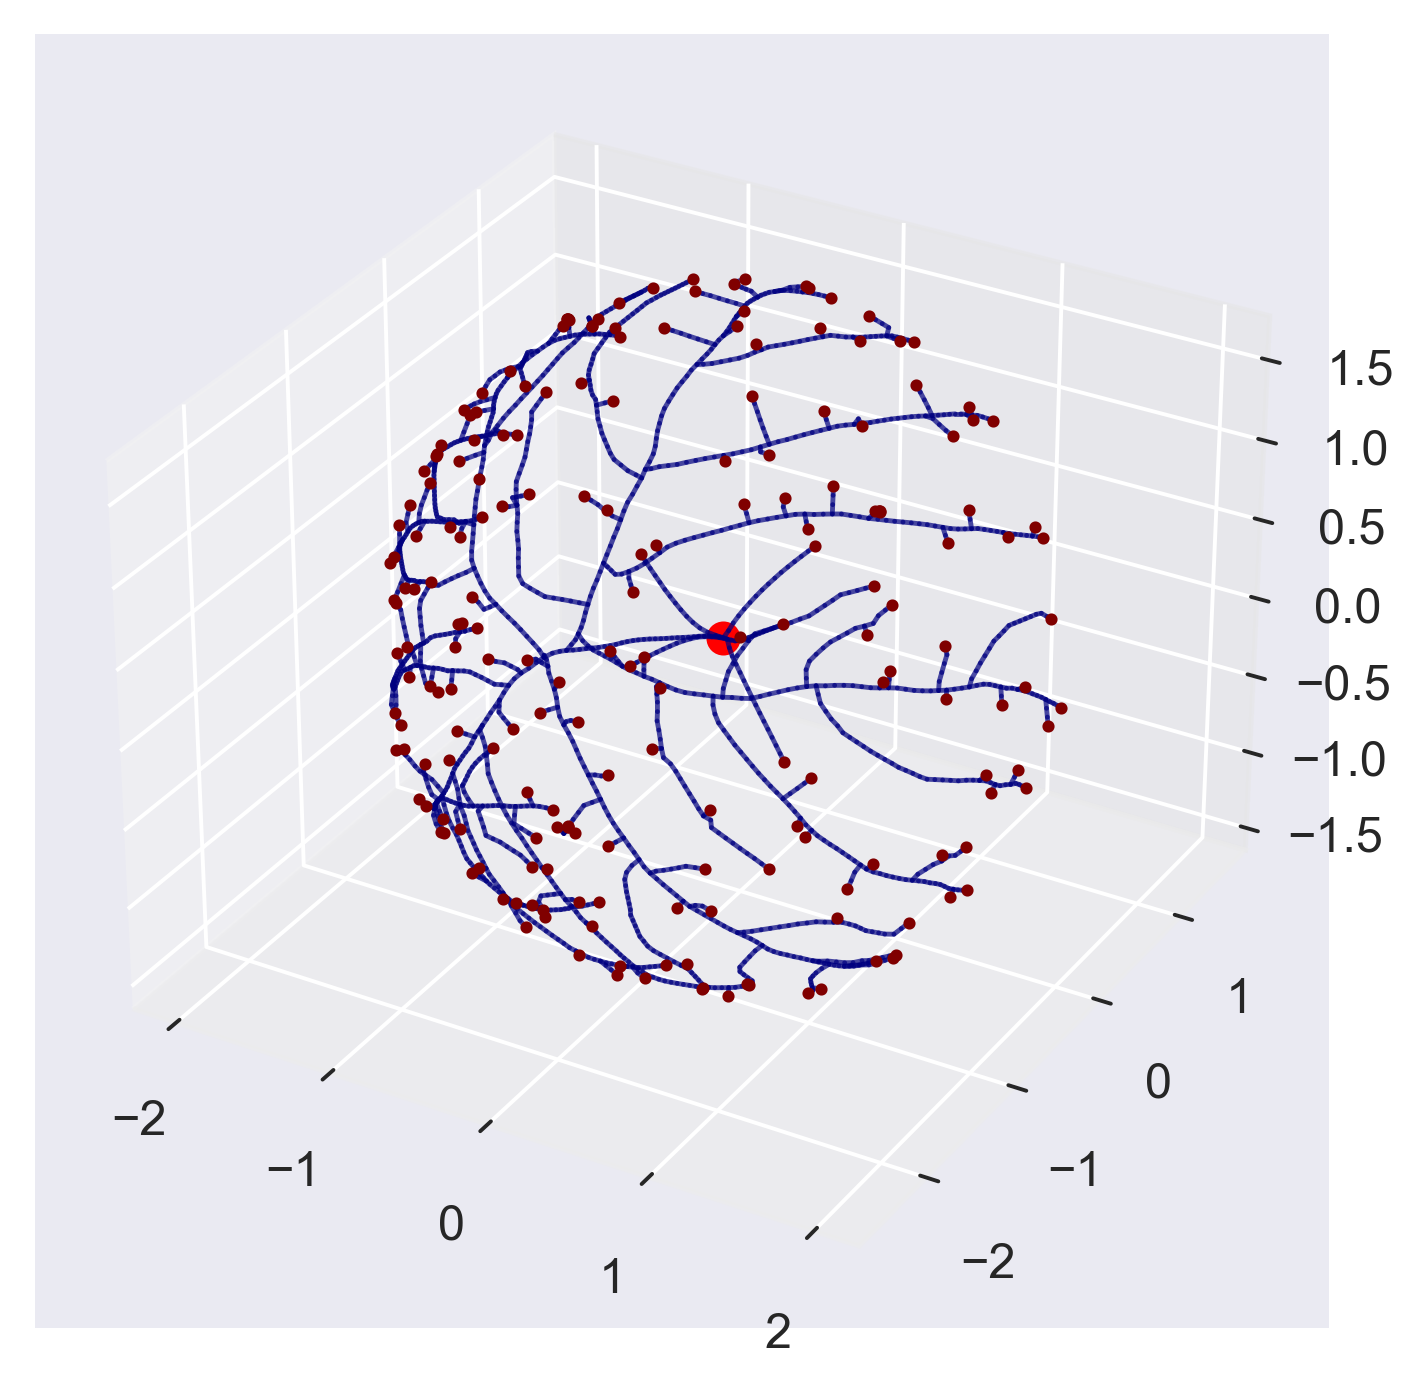

In [123]:
tree = set()
root = TreeNode([-0,-0.2, 0.1], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=100,
                                                 Di=1,
                                                 Dg=0.05,
                                                 Dk=0.1,
                                                )
SCA.plot_tree(new_tree, root)

In [124]:
G = tree_to_graph(new_tree, root)

In [125]:
# list(get_tips(G))

In [126]:
import sys
sys.path.insert(1, '/Users/anyak/Documents/Lab/SWC/astroTanya')
sys.path.insert(1, '/Users/anyak/Documents/Lab/neuro.im-proc')
import astrobject
from astrobject import ascii, Table

import tmd 
from tmd.view import view, plot
import morphio 
import neurom as nm
from neurom.view import matplotlib_impl, matplotlib_utils

In [127]:
save_path_swc = '/Users/anyak/Documents/Lab/SWC/SCA_swc'

name = ['astro_junior', '']
ratio=(100, 100, 100)
cell_type = 7
filename = save_path_swc + f'/{name[0]}.swc'
center = tuple([i.v for i in tree if i.parent == None][0])

In [128]:

obj_classic = astrobject.AG(G).swc(center=center)

  0%|          | 0/1 [00:00<?, ?it/s]

In [129]:
def swc_save(data, cell_type, filename, ratio=None, sigmas_rad = False, sigmas_vals = None):
    astro = data
    lines = []
    keys = ['#index', 'type ', 'X ', 'Y ', 'Z ', 'radius ', 'parent', '\n']
    soma = 1
    radius = 0.125

    data = Table()
    # ratio = ratio if ratio else self.ratio

    X = []
    Y = []
    Z = []
    POS = []
    PAR = []

    for r in astro:
        for n in r.items():
            x, y, z = n[0]
            X.append(x)
            Y.append(y)
            Z.append(z)
            pos, par = n[1]
            POS.append(pos)
            PAR.append(par)

    ntype = np.full(len(POS), cell_type)
    ntype[0] = 1
    
    if sigmas_rad == True:
        
        if sigmas_vals == None:
            print('Add sigmas values')
            
        radius = [radius]
        filename = out + f'/{name}_rads.swc'
        
        for z in list(zip(X, Y, Z))[1:]:
            #  половина сигмы --- радиус
            radius.append((sigmas_vals[z])/2)
        radius = np.array(radius)

    data['#index'] = np.array(POS)
    data['type'] = ntype
    data['X'] = np.array(X) * ratio[0]
    data['Y'] = np.array(Y) * ratio[1]
    data['Z'] = np.array(Z) * ratio[2]
    data['radius'] = radius
    data['parent'] = np.array(PAR)

    data.write(filename, format='ascii', overwrite=True)

In [130]:
swc_save(obj_classic, cell_type=cell_type, filename=filename, ratio = ratio)

In [138]:
cell = tmd.io.load_neuron(filename)

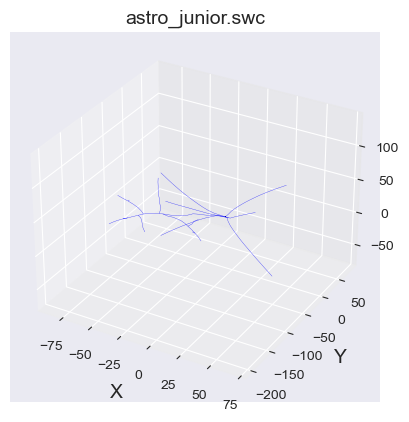

In [133]:
matplotlib_impl.plot_morph3d(morphology, color='blue')

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': '/Users/anyak/Documents/Lab/SWC/SCA_swc/astro_junior'}, xlabel='x', ylabel='y'>)

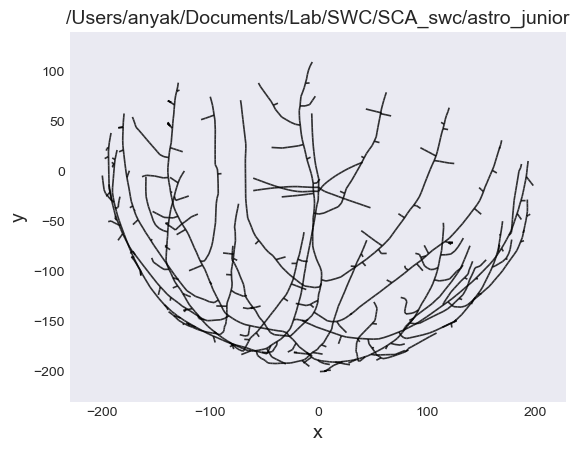

In [139]:
view.neuron(cell, nosoma=True, diameter=False)

In [136]:
ph_astro = tmd.methods.get_ph_neuron(cell)

(array([[2.62663222e-002, 2.43922470e-002, 2.14193396e-002, ...,
         5.67470496e-153, 3.95084910e-156, 2.55085301e-159],
        [2.82519288e-002, 2.73238161e-002, 2.50662357e-002, ...,
         3.97719072e-150, 2.96706777e-153, 2.05399381e-156],
        [2.88909620e-002, 2.90034775e-002, 2.76844055e-002, ...,
         2.54825568e-147, 2.03994656e-150, 1.51928283e-153],
        ...,
        [7.74850690e-003, 6.50407049e-003, 5.06189907e-003, ...,
         6.16016050e-001, 5.73244795e-001, 5.02181837e-001],
        [8.87859987e-003, 7.98212176e-003, 6.65354716e-003, ...,
         5.49050084e-001, 5.35252853e-001, 4.91952937e-001],
        [9.29080412e-003, 8.94610142e-003, 7.98684686e-003, ...,
         4.63796423e-001, 4.72981477e-001, 4.55587463e-001]]),
 (<Figure size 640x480 with 1 Axes>,
  <AxesSubplot: title={'center': 'Persistence image'}, xlabel='End radial distance from soma', ylabel='Start radial distance from soma'>))

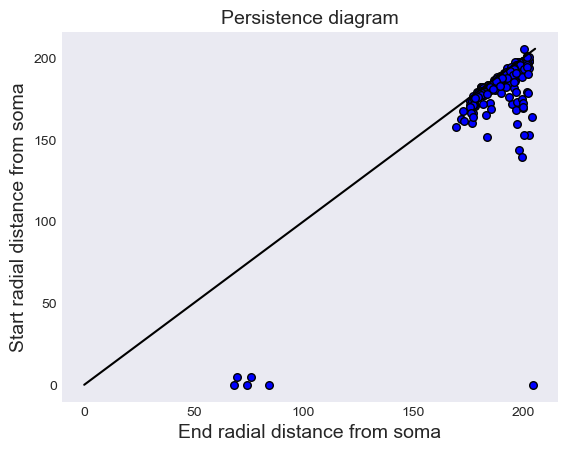

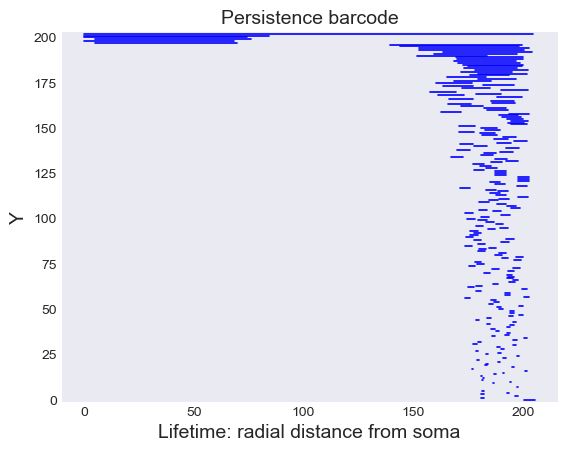

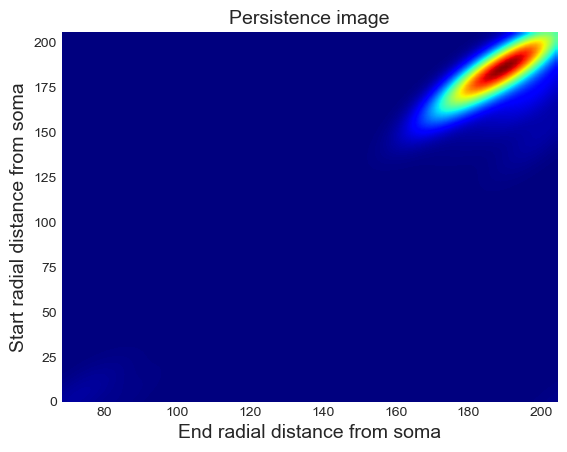

In [137]:
plot.diagram(ph_astro, subplot=True)
# plt.savefig('diagram.png', dpi=300)

plot.barcode(ph_astro, subplot=True)
# plt.savefig('barcode.png', dpi=300)

plot.persistence_image(ph_astro, subplot=True)
# plt.savefig('persistence_image.png', dpi=300)

In [195]:
def set_thickness(graph, sigma):
    for n in graph.nodes:
        weight = nx.dfs_successors(graph, n)
        rad = 

In [196]:
new = set_thickness(tree, sigma=0.5)

In [208]:
1 - np.exp(-0.00001*9000)

0.08606881472877181

# Synapses

In [46]:
class Synapse:
    def __init__(self, coords):
        self.age = 0
        self.coords = coords
        self.nodes = None
        self.alive = True
        self.mature = False
    
    def age_flag(self):
        ms = self.age + 0.5
        alpha = 1/(self.age+1)
        color = 'r'
        if self.age > 5:
            ms = 6
            alpha = 0.25
            color = 'maroon'

        kwards = {'ms': ms,
                  'color': color,
                  'alpha': alpha
        }
        return kwards

def generate_random_synapse(radius):
    coords = radius*(np.random.rand(1,3) - 0.5)[0]
    synapse = Synapse(coords)
    return synapse

In [48]:
# нужна функция апдейта синапсов на каждом новом цикле роста дерева
def generate_synapse(tree, radius, Dk, Dg):
    coords = radius*(np.random.rand(1,3) - 0.5)[0]
    synapse = Synapse(coords)
    kdt = sp.spatial.KDTree([n.v for n in tree])
    d,inds = kdt.query(synapse.coords, distance_upper_bound=Dg*10)
    if d < Dg*10 and d > Dk:
        return synapse
    else:
        return generate_synapse(tree, radius, Dk, Dg)

def update_synapses(tree, synapses, Dk, Dg, eprob, radius=2, life_cycle=45):
    new_synapses = list(synapses)
    p = eprob

    for s in new_synapses:
        if s.age > life_cycle:
            s.alive = False
        s.age += 1

    while p <1:
        synapse = generate_synapse(tree, radius, Dk, Dg)
        if len(synapse.coords) == 0:
            continue
        new_synapses.append(synapse)
        p += np.random.uniform(0,0.5)
    
    new_synapses = list(filter(lambda x: x.alive == True, synapses))
    new_synapses = list(filter(lambda x: x.coords.shape != np.array([]).shape, synapses))
    return np.array(new_synapses)

In [49]:
def space_colonization_synupd(tree, sources, iterations=20, Dg=0.025, Di=1, Dk=0.025, upd_cycle = 50):
   
    for j in tqdm(range(iterations)):

        if j > upd_cycle:
            sources = update_synapses(tree, sources, Dk, Dg, eprob=-1)
        
        tree_prev = [n for n in tree if len(n.children) <= n.max_branches]
        
        kdt = sp.spatial.KDTree([n.v for n in tree_prev])
        
        sources_coords = [s.coords for s in sources]

        d,inds = kdt.query(sources_coords, distance_upper_bound=Di)
            
        if len(d) and np.min(d) > Di:
            d,inds = kdt.query(sources_coords, distance_upper_bound=np.min(d))
            
        for i, n in enumerate(tree_prev):
            S = sources[inds==i]
            S = [s.coords for s in S]
            n.spawn(S, Dg)
                    
        kdt2 = sp.spatial.KDTree([n.v for n in tree])
        too_close = kdt2.query_ball_point(sources_coords, Dk, return_length=True)        
        sources = sources[too_close == 0] 
        
        if not len(sources):
            break
        
        # add small jitter to break up ties
        for s in sources:
            s.coords = s.coords + np.random.randn(*s.coords.shape)*Dg*0.05

    return tree, sources

In [ ]:
life_cycle = 45
Npoints = 500
sources = 2*(np.random.rand(Npoints,3) - 0.5)
sources_syn = np.array([Synapse(s) for s in sources])
for ss in sources_syn:
    ss.age = -50
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree_syn, remaining_sources = space_colonization_synupd(tree, sources_syn, 
                                                 iterations=1500,
                                                 Di=1,
                                                 Dg=0.005,
                                                 Dk=0.01,
                                                 upd_cycle=50
                                                )
plot_tree(new_tree_syn, root, sources, show_phase=45)
plt.suptitle('Space colonization: synapse update', weight='bold',fontsize=24, y=1)
plt.title('Di=1, Dg=0.005, Dk=0.01, iteration=1500, points=500',fontsize=12)

In [61]:
# def func(foo, num):
#     return foo(num)

import numpy as np

def func(foo):

    p = foo()
    # if foo == True:
    #     return 'Success!'
    while p == True:
        print('Success!')
        p = foo()

def Wow():
    if np.random.random() > 0.5:
        return True
    else:
        return False


In [70]:
func(Wow)

Success!
Success!
Success!
Success!


## SWC

# Sholl Distr

In [2]:
def sholl_distribution():
    pass

# Synapses

# Voronoi

In [15]:
from shapely.geometry import LineString, Polygon


In [39]:
def Verts(radius, center=(0, 0, 0), lines=True):
    Xc, Yc, Zc = center
    SL = radius
    Verts = np.array([[Xc + SL/2, Yc + SL/2, Zc + SL/2], 
             [Xc + SL/2, Yc + SL/2, Zc - SL/2],
             [Xc + SL/2, Yc - SL/2, Zc + SL/2],
             [Xc + SL/2, Yc - SL/2, Zc - SL/2],
             [Xc - SL/2, Yc + SL/2, Zc + SL/2],
             [Xc - SL/2, Yc + SL/2, Zc - SL/2],
             [Xc - SL/2, Yc - SL/2, Zc + SL/2],
             [Xc - SL/2, Yc - SL/2, Zc - SL/2]])
    if lines ==True:
        Lines = []
        for i in Verts:
            x, y, z = i
            for j in Verts:
                xx, yy, zz = j
                if x == xx and y == yy and z == zz:
                    continue
                if x == xx and y == yy:
                    Lines.append([i, j])
                elif x == xx and z == zz:
                    Lines.append([i, j])
                elif y == yy and z == zz:
                    Lines.append([i, j])
                else:
                    continue
            Lines = set(Lines)
        return np.array(list(Lines))

    return Verts

def inside_cube(points, vertices):
    deln = sp.spatial.Delaunay(vertices) 
    out_idx = np.flatnonzero(deln.find_simplex(points) + 1)
    inside_points = points[out_idx]
    return out_idx, inside_points

def Voronoi(points):
    vor = sp.spatial.Voronoi(points)


In [40]:
verts = Verts(1)
# inside = inside_cube(vor_vertex_coords, verts)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# ax.plot(verts[:, 0], verts[:, 1], verts[:, 2], 'o')

TypeError: unhashable type: 'list'

In [41]:
verts

array([[[ 0.5,  0.5,  0.5],
        [ 0.5,  0.5, -0.5]],

       [[ 0.5,  0.5,  0.5],
        [ 0.5, -0.5,  0.5]],

       [[ 0.5,  0.5,  0.5],
        [-0.5,  0.5,  0.5]],

       [[ 0.5,  0.5, -0.5],
        [ 0.5,  0.5,  0.5]],

       [[ 0.5,  0.5, -0.5],
        [ 0.5, -0.5, -0.5]],

       [[ 0.5,  0.5, -0.5],
        [-0.5,  0.5, -0.5]],

       [[ 0.5, -0.5,  0.5],
        [ 0.5,  0.5,  0.5]],

       [[ 0.5, -0.5,  0.5],
        [ 0.5, -0.5, -0.5]],

       [[ 0.5, -0.5,  0.5],
        [-0.5, -0.5,  0.5]],

       [[ 0.5, -0.5, -0.5],
        [ 0.5,  0.5, -0.5]],

       [[ 0.5, -0.5, -0.5],
        [ 0.5, -0.5,  0.5]],

       [[ 0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5]],

       [[-0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5]],

       [[-0.5,  0.5,  0.5],
        [-0.5,  0.5, -0.5]],

       [[-0.5,  0.5,  0.5],
        [-0.5, -0.5,  0.5]],

       [[-0.5,  0.5, -0.5],
        [ 0.5,  0.5, -0.5]],

       [[-0.5,  0.5, -0.5],
        [-0.5,  0.5,  0.5]],

       [[-0.5,

(-0.7573930625524492, 0.8816572091493511)

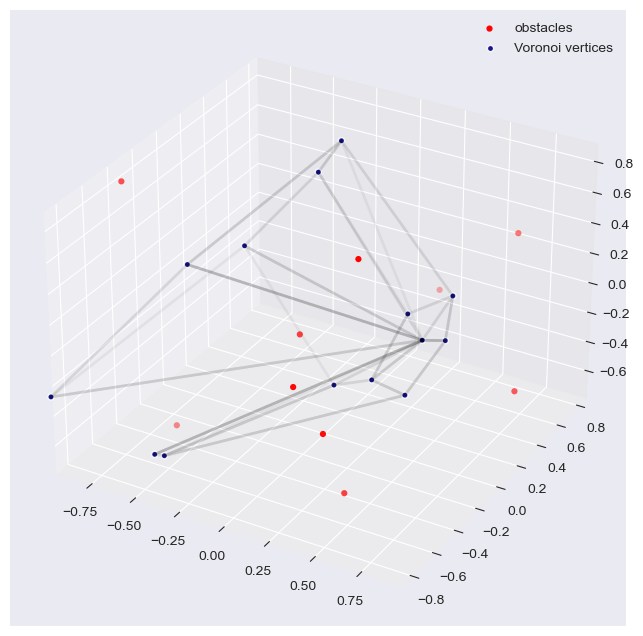

In [41]:
Cloud = PointCloud(Npoints=10)
data = Cloud.Cube()
#the edges of a 3D Voronoi diagram will be the farthest from the obstacle coordinates
vor = sp.spatial.Voronoi(data)
        
fig_drone_3d = plt.figure()
fig_drone_3d.set_size_inches(8,8)
ax = fig_drone_3d.add_subplot(111, projection = '3d')

for ridge_indices in vor.ridge_vertices:
    voronoi_ridge_coords = vor.vertices[ridge_indices]
    ax.plot(voronoi_ridge_coords[...,0], voronoi_ridge_coords[...,1], voronoi_ridge_coords[...,2], lw=2, c = 'k', alpha = 0.05)
    
vor_vertex_coords = vor.vertices

ax.scatter(data[...,0], data[...,1], data[...,2], c= 'r', label='obstacles', edgecolor='none')
ax.scatter(vor_vertex_coords[...,0], vor_vertex_coords[...,1], vor_vertex_coords[...,2], c= 'navy', label='Voronoi vertices',edgecolors='white', marker = 'o', alpha = 0.9)
ax.legend()
ax.set_xlim3d(data[...,0].min(), data[...,0].max())
ax.set_ylim3d(data[...,1].min(), data[...,1].max())
ax.set_zlim3d(data[...,2].min(), data[...,2].max())

(-0.7573930625524492, 0.8816572091493511)

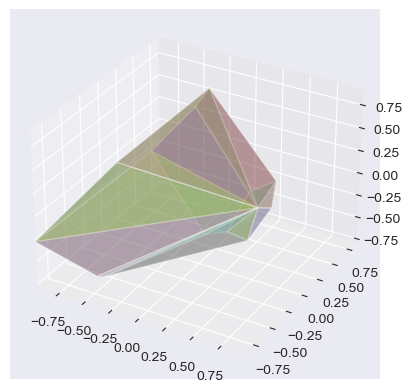

In [42]:
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
for ridge_indices in vor.ridge_vertices:
    vtx = vor.vertices[ridge_indices]
    # vtx = np.random.rand(3,3)
    tri = a3.art3d.Poly3DCollection([vtx], alpha=0.2)
    tri.set_color(colors.rgb2hex(np.random.rand(3)))
    tri.set_edgecolor('white')
    ax.add_collection3d(tri)
ax.set_xlim3d(data[...,0].min(), data[...,0].max())
ax.set_ylim3d(data[...,1].min(), data[...,1].max())
ax.set_zlim3d(data[...,2].min(), data[...,2].max())

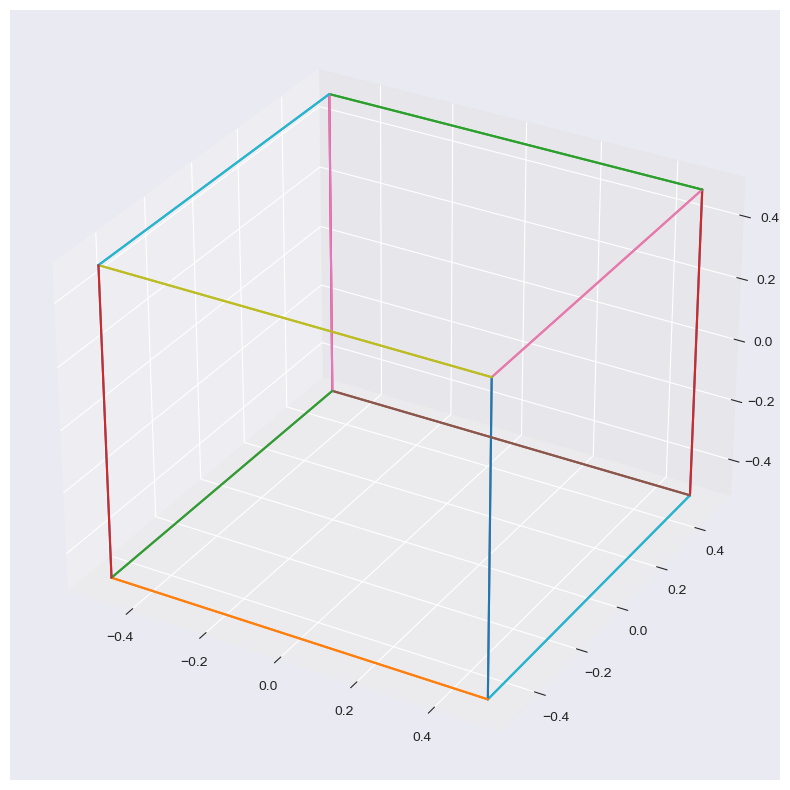

In [24]:
# V1: Shapely intersec
# 6 cube planes
# N lines (vertices)

# cube
axes = [1, 1, 1]
cube = np.ones(axes)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
# for ridge_indices in vor.ridge_vertices:
#     voronoi_ridge_coords = vor.vertices[ridge_indices]
#     line_verts = LineString(voronoi_ridge_coords)
#     ax.plot(*line_verts.xy)

# ax.set_xlim3d(data[...,0].min(), data[...,0].max())
# ax.set_ylim3d(data[...,1].min(), data[...,1].max())
# ax.set_zlim3d(data[...,2].min(), data[...,2].max())

# ax.voxels(cube, alpha=0.1)

for j in Verts(1):
    ax.plot(j[:, 0], j[:, 1], j[:,2])

In [30]:
from SCA import Space_colonization
import SCA

In [39]:
test_space = Space_colonization(root=[-0,-0.2, 0.1], sources=sources)
test_space.go_tree_classic()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
t, r, s = test_space.tree, test_space.root, test_space.sources

/Users/anyak/Documents/Lab/AstroSpace/AstroSpace-main/AstroSpace/SCA.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], vx[:, 2], 'k-', lw=1, color = 'navy', alpha=0.7)


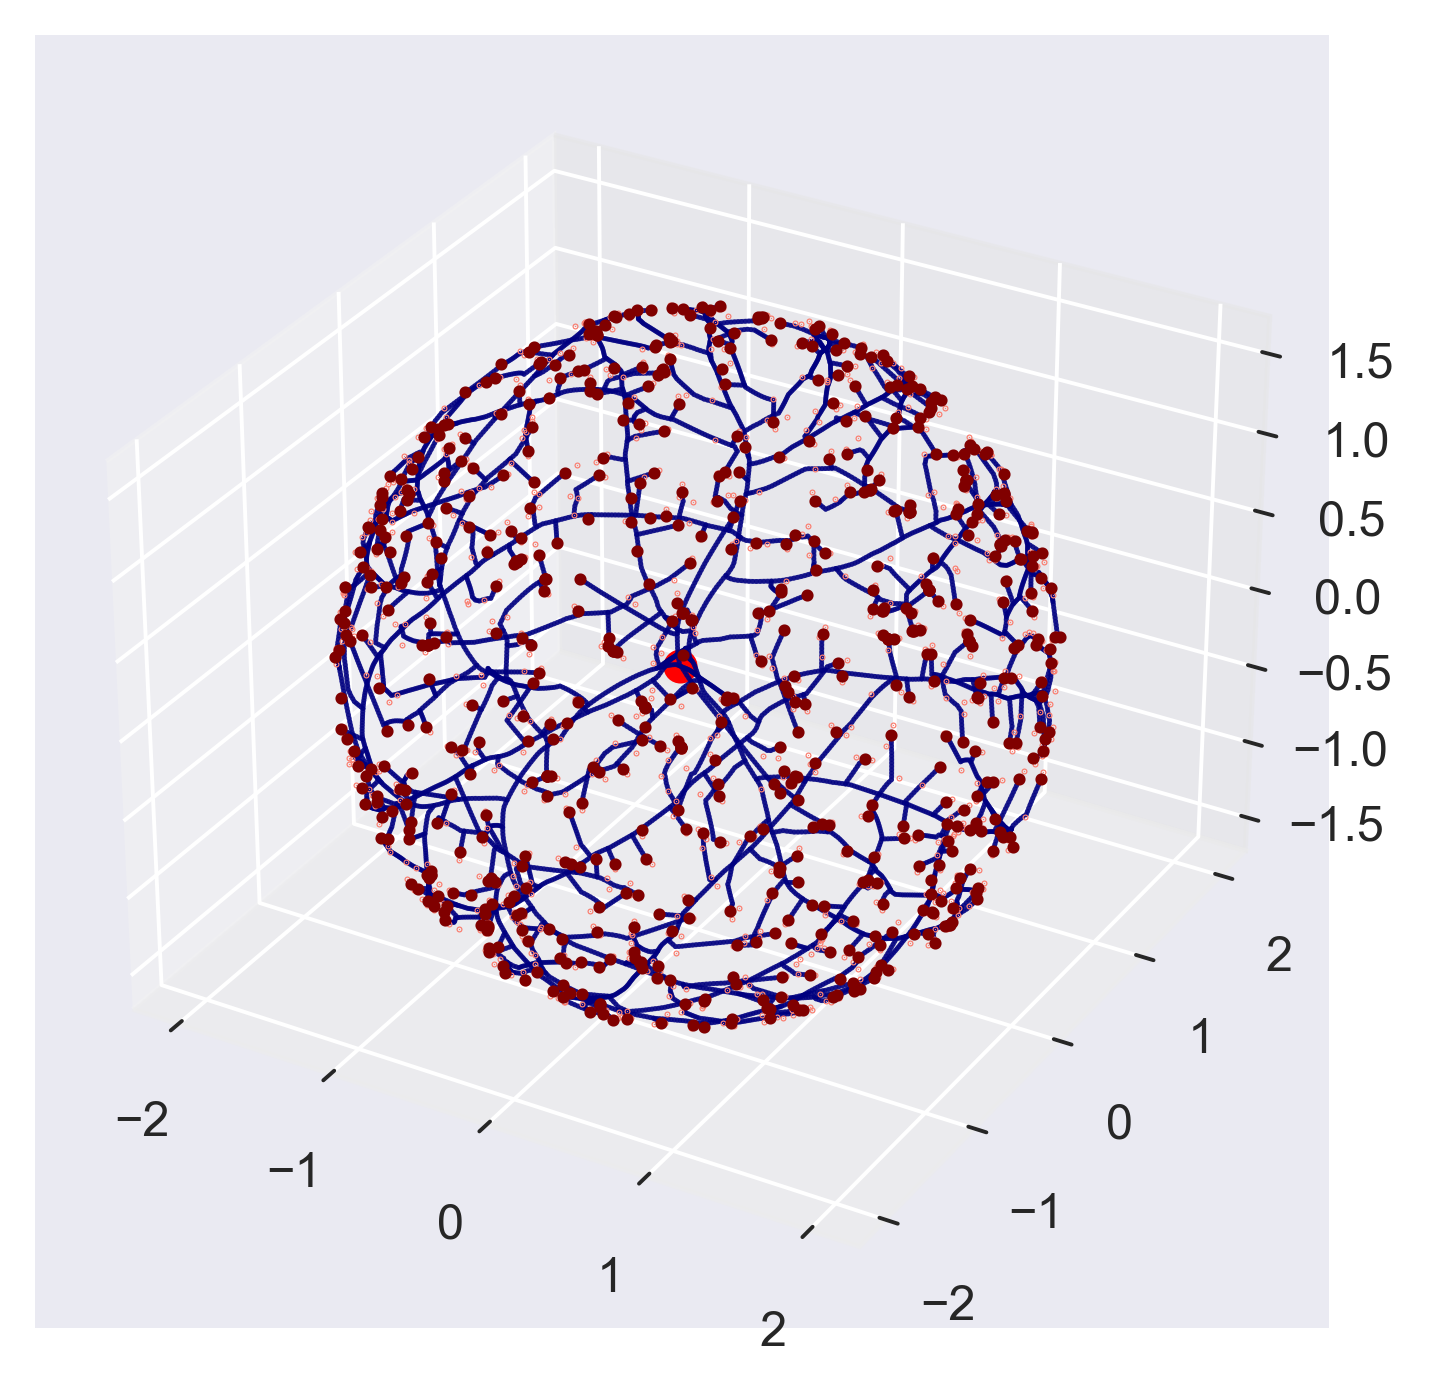

In [43]:
SCA.plot_tree(t, r, s)